In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import pprint as pp

### Single Neuron

In [2]:
inputs = [1, 2, 3]
weights = [0.2, 0.8, -0.5]
bias = 2

output = (
    inputs[0] * weights[0] +
    inputs[1] * weights[1] +
    inputs[2] * weights[2] +
    bias
)
print(output)
print(output == np.array(inputs).T @ np.array(weights) + bias)

2.3
True


### Layer of Neurons

In [3]:
inputs = np.array([1, 2, 3, 2.5])
wei = np.random.rand(4,3)
b = np.array([2, 3, 0.5])

output = inputs.T @ wei + b
print('weights:')
pp.pprint(wei)
print('output:')
pp.pprint(output)

weights:
array([[0.36716305, 0.97199762, 0.13900794],
       [0.90758721, 0.05489454, 0.0208142 ],
       [0.14357147, 0.89077087, 0.13425076],
       [0.05236642, 0.21677923, 0.28777375]])
output:
array([4.74396792, 7.29604738, 1.80282299])


Each neuron is a column vector in the weights matrix `wei`

## Training Data

In [4]:
from nnfs.datasets import spiral_data
import nnfs

The `spiral_data` function allows us to create a non-linear dataset with user-defined numbers of observations and classes. This example has 3 classes with 100 observations in each:

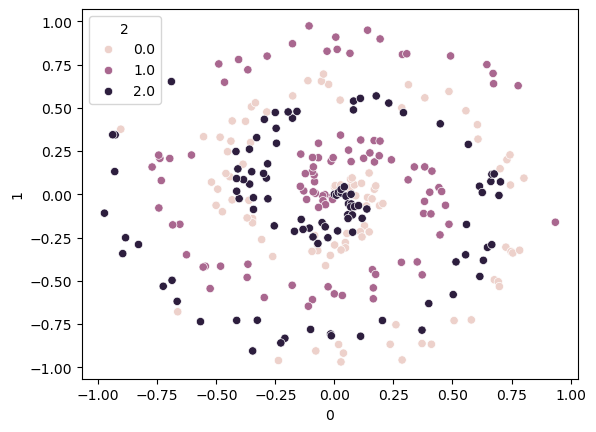

In [5]:
import seaborn as sns
import pandas as pd
X, y = spiral_data(samples=100, classes=3)  # y is the class assignments
# plt.scatter(X[:, 0], X[:, 1])
df = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1))
sns.scatterplot(data=df, x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df.iloc[:, 2])
plt.show();

So, we have 300 observations distributed across 3 classes. These classes correspond to the separate arms of the spiral in this plot. This would be super difficult to classify using more conventional classification models. Parametric models would certainly perform poorly but as would non-parametric, unsupervised models like clustering or ensemble models. This is because approaches that hinge on partitioning the predictor space will clearly group distinct classes together. So, we need something more flexible.

## Dense Layer Class

A layer of neurons is ***Fully Connected*** or ***Dense*** when every neuron in the layer receives an input *and connects to every neuron in the next layer*. Layers are commonly fully connected but they do not need to be. We could deliberately create layers with extraneous unconnected neurons, though to facilitate the matrix multiplication structure of a network we would do this by simply zeroing out the unconnected neurons rather than omitting them.

In [11]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = inputs @ self.weights + self.biases

In [13]:
dense1 = Layer_Dense(2, 3)
dense1.forward(X)
dense1.output[:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.37551921e-05, -6.44149725e-05,  2.35419134e-04],
       [-3.09746364e-06, -5.81485125e-05,  5.52122112e-04],
       [-2.31430048e-04, -1.77289479e-04,  7.58787258e-04],
       [-4.87756543e-04, -2.86273944e-04,  7.50166803e-04]])

## Activation Functions

So far, the operations of the neural network that we've implemented are all linear. Really, just simple addition and multiplication. Both of which are linear operators. For this reason, neural layers within a mulit-layer network architecture are often called ***Linear Layers***. Activation functions are applied to the outputs of the linear layers to introduce nonlinearity which allows the model to approximate nonlinear functional forms. A generic architecture will often have activation functions between each hidden layer of the network and then a separate activation function for the final output.

**Sigmoid Activation:**
$$y = \frac{1}{1+e^{-x}}$$

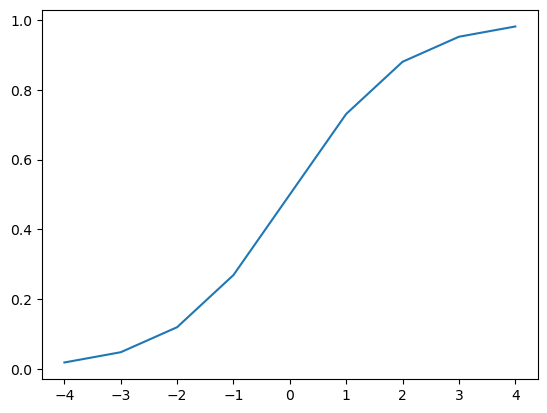

In [25]:
def sigmoid(x): return 1 / (1 + np.exp(-x))
sns.lineplot(x=np.arange(-4, 5), y=sigmoid(np.arange(-4, 5)));

**Rectified Linear Activation Function (RELU):**
$$y = \begin{cases} x, \ x > 0 \\ 0, \ x \le 0 \end{cases}$$

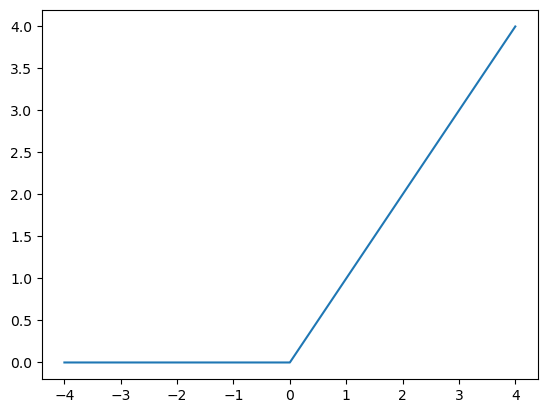

In [24]:
def relu(x): return np.maximum(x, 0)
sns.lineplot(x=np.arange(-4, 5), y=relu(np.arange(-4,5)));

These are two of the most common activation functions. Note that in addition to being non-linear functions, they also effectively zero-out neurons whose outputs are negative. The effect of this is to prevent training (via backpropogation) of neurons that are not "firing"... more on this later

### Why Use Activation Functions?

In general, to approximate a nonlinear function with a neural network we need:
- at least two hidden layers
- a non-linear activation function

If we have do not have a  non-linear activation funciton, then the entire network, no matter how many layers deep, is a linear system of equations. So long as the input is a vector (or set of vectors) of scalar values, the output will *always* be linear. 

Let's look at how a non-linear activation function like RELU can rectify this. 

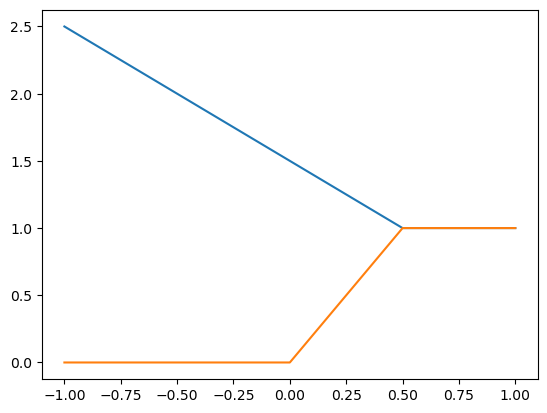

In [59]:
inputs = np.array([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])

n1, n2 = -1, 1      # two neurons with one weight each
n21, n22 = -1, -2   # alternative weights

b1, b2 = 0.5, 1     # one bias for each neuron

out1 = relu(relu((inputs * n1 + b1)) * n2 + b2)
out2 = relu(relu((inputs * n21 + b1)) * n22 + b2)
sns.lineplot(x=inputs, y=out1);
sns.lineplot(x=inputs, y=out2);

If we play around with these weights, we can see that a wide range of outputs are achievable depending on the weight values. Note the second weight configuration associated with `out2`. There is now both an activation and a *deactivation* point. That is, there is a range of outputs wherein both neurons are activated and they produce a sort of "area of effect". 

**Demo Approximating a Sine Wave:**
This demo approximates a sine wave with two hidden layers and RELU activations. The hidden layers *are not dense*, they neurons in the first layer only connect to the next neurons in the second layer.

In [135]:
x = np.arange(0, 1, 0.01)
y = np.sin(2 * np.pi *x)

w1 = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # layer 1 - eight neurons with one weight each
w2 = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # layer 2 - eight neurons with one weight each
b1 = np.array([0, 0, 0, 0, 0, 0, 0, 0])
b2 = np.array([0, 0, 0, 0, 0, 0, 0, 0])

out = np.array([0, 0, 0, 0, 0, 0, 0, 0])  # output layer - ONE neuron with eight weights

# forward through the linear layers given input x
# implemented as a one-to-many loop
def forward(x):
    l1 = relu((x * w1 + b1))
    l2 = relu((w2 * l1 + b2))
    return l2 @ out.T

# # for visualization
def plot_nn():
    outputs = np.array([forward(i) for i in x])
    sns.lineplot(x=x, y=y)
    sns.lineplot(x=x, y=outputs)
    plt.show();

Now we can manually adjust the weights and biases to approximate the sin wave:

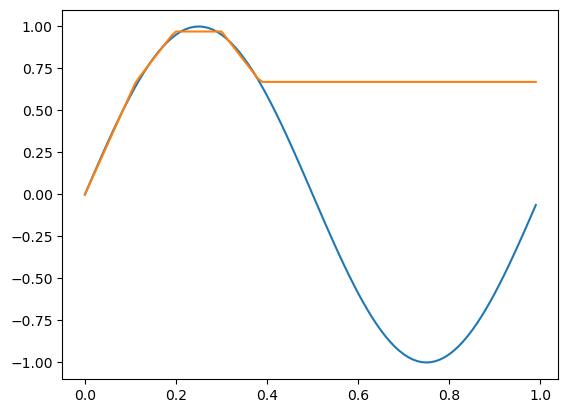

In [133]:
# first layer
w1 = np.array([6, 3.5, -3.5, -6, 0, 0, 0, 0])
b1 = np.array([0, -0.42, 1.35, 1, 0, 0, 0, 0])

# second layer
w2 = np.array([-1, -1, -1, -1, 0, 0, 0, 0])
b2 = np.array([0.7, 0.27, 0.3, 0, 0, 0, 0, 1])

# output neuron
out = np.array([-1, -1, -1, -1, 0, 0, 0, 0.97])

plot_nn()

You get the picture...

### Softmax Activation

Very commonly used in classification settings because it maps to a domain of $[0,1]$ that is interpretable as probabilities.
$$S_{i,j} = \frac{e^{z_{i,j}}}{\sum_{l=1}^L e^{z_{i,j}}}$$

In [134]:
def softmax(x): 
    ex = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return ex / np.sum(ex, axis=1, keepdims=True)

Note that the max is deducted from each value in `x`, this is to promote numerical stability, sepcifically to prevent neurons from "exploding". Moderately large values in `x` can quickly lead to overflow errors, so large weights can break things quickly. However, negative exponents trend towards 0 as the input value approaches negative infinity.

## Loss